In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io

In [2]:
img_base_url = "https://yoyoyo-yo.github.io/Gasyori100knock/"

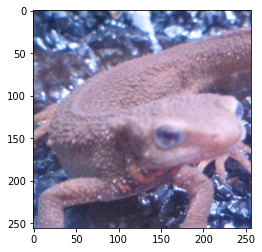

In [3]:
img_orig = io.imread(img_base_url + "dataset/images/imori_256x256.png")
plt.imshow(img_orig)

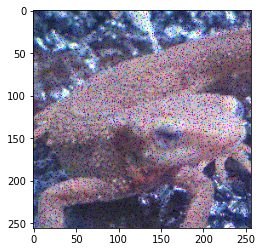

In [4]:
img_noise_orig = io.imread(img_base_url + 'dataset/images/imori_256x256_noise.png')
plt.imshow(img_noise_orig)

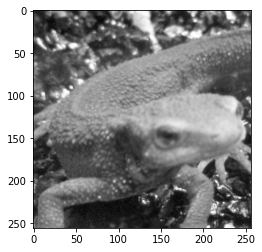

In [5]:
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap='gray')

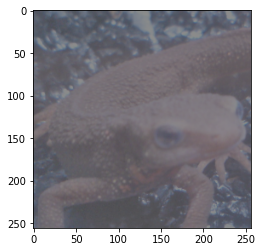

In [6]:
img_dark = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_dark.png')
plt.imshow(img_dark)

## Question 21 ヒストグラム正規化 Histogram normalization

ヒストグラムは偏ることがある。 例えば、0に近い画素が多ければ画像は全体的に暗く、255に近い画素が多ければ画像は明るくなる。 ヒストグラムが局所的に偏っていることをダイナミックレンジが狭いなどと表現する。 そのため画像を人の目に見やすくするために、ヒストグラムを正規化したり平坦化したりなどの処理が必要である。

このヒストグラム正規化は濃度階調変換(gray-scale transformation) と呼ばれ、[c,d]の画素値を持つ画像を[a,b]のレンジに変換する場合は次式で実現できる。

![](https://github.com/yoyoyo-yo/Gasyori100knock/raw/master/questions/question_21_30/images/hist_norm_equ.png)

今回はimori_256x256_dark.pngを[150, 200]のレンジにそれぞれ変換する。

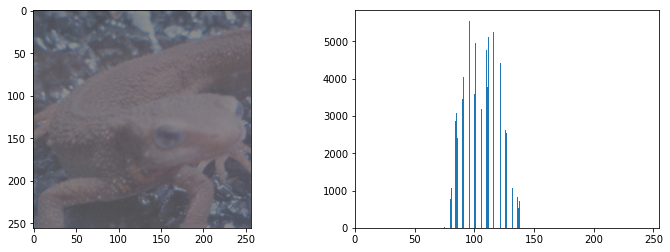

In [7]:
# 元々のヒストグラムはこれ　　明らかに画像は暗く、ヒストグラムも偏っている
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.imshow(img_dark);
plt.subplot(1, 2, 2); plt.hist(img_dark.ravel(), bins=255);
plt.xlim([0, 255]); plt.show()

In [8]:
img_dark.min(), img_dark.max()

(71, 140)

In [9]:
def hist_normalize(img, a, b):
    c, d = img.min(), img.max()
    # if c <= xin < d
    out = (b - a) / (d - c) * (img - c) + a
    # if xin < c
    out[img < c] = a
    # if xin > d
    out[img > d] = b
    return np.clip(out, 0, 255).astype(np.uint8)

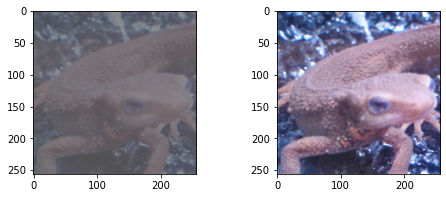

In [10]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(img_dark)
plt.subplot(1, 2, 2)
plt.imshow(hist_normalize(img_dark, 0, 255))

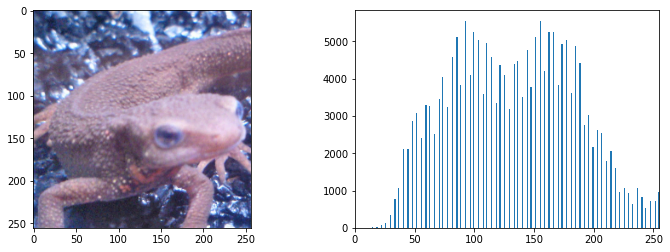

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.imshow(hist_normalize(img_dark, 0, 255));
plt.subplot(1, 2, 2); plt.hist(hist_normalize(img_dark, 0, 255).ravel(), bins=255);
plt.xlim([0, 255]); plt.show()

## Question 22 ヒストグラムのスケーリングとシフト Histogram scaling and shift

ヒストグラムの平均値を$m0=128$、標準偏差を$s0=50$になるように操作せよ。

これはヒストグラムのダイナミックレンジを変更するのではなく、ヒストグラムを平坦に変更する操作である。

もともとが平均値 $m_0$ 、標準偏差 $s_0$ 、のヒストグラムを平均値m, 標準偏差sに変更するには、次式によって変換する。

![](https://github.com/yoyoyo-yo/Gasyori100knock/raw/master/questions/question_21_30/images/hist_norm_equ.png)

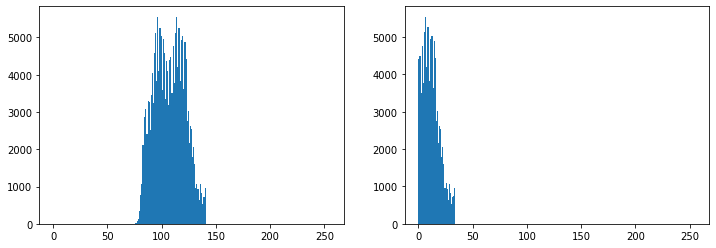

In [12]:
# 原理 1
# xin - m0 は画素の平均を0にする操作
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.hist(img_dark.ravel(), bins=255, range=(0, 255))
plt.subplot(1, 2, 2); plt.hist((img_dark - img_dark.mean()).ravel(), bins=255, range=(0, 255))
plt.show()

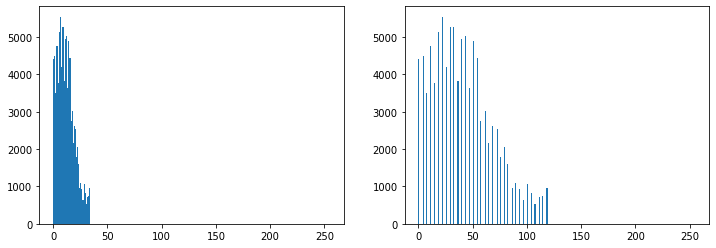

In [13]:
# 原理 2
# s / s0 は画素のstdを1にした後、希望の値にスケーリングする操作
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.hist((img_dark - img_dark.mean()).ravel(), bins=255, range=(0, 255))
plt.subplot(1, 2, 2); plt.hist( 50 / img_dark.std() * (img_dark - img_dark.mean()).ravel(), bins=255, range=(0, 255))
plt.show()

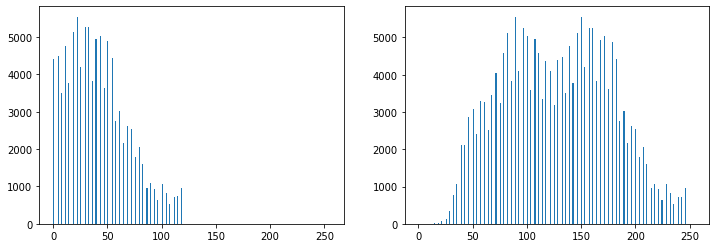

In [14]:
# 原理 3
# + m は希望のmeanにシフトする操作
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.hist( 50 / img_dark.std() * (img_dark - img_dark.mean()).ravel(), bins=255, range=(0, 255))
plt.subplot(1, 2, 2); plt.hist( 50 / img_dark.std() * (img_dark - img_dark.mean()).ravel() + 128, bins=255, range=(0, 255))
plt.show()

In [15]:
def hist_scaleshift(img, m, s):
    m0, s0 = img.mean(), img.std()
    out = s / s0 * (img - m0) + m
    return np.clip(out, 0, 255).astype(np.uint8)

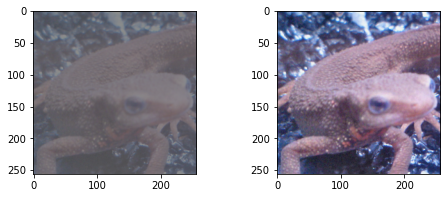

In [16]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(img_dark)
plt.subplot(1, 2, 2)
plt.imshow(hist_scaleshift(img_dark, m=128, s=50))

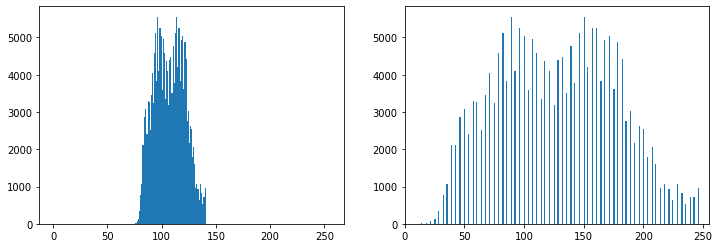

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.hist(img_dark.ravel(), bins=255, range=(0, 255));
plt.subplot(1, 2, 2); plt.hist(hist_scaleshift(img_dark, 128, 50).ravel(), bins=255, range=(0, 255));
plt.xlim([0, 255]); plt.show()

## Question 23 ヒストグラム平坦化 Histogram equalization

ヒストグラム平坦化を実装せよ。

ヒストグラム平坦化とはヒストグラムを平坦に変更する操作であり、上記の平均値や標準偏差などを必要とせず、ヒストグラム値を均衡にする操作である。

画素がxのものは次式の変化でx'になる

S ... 画素の総数 (height x width x channel)、$x_{max}$ ... 画素値の最大値、h(i) ... 画素iの数

![](https://github.com/yoyoyo-yo/Gasyori100knock/raw/master/questions/question_21_30/images/hist_equ_equ.png)

MEMO: ヒストグラムの中央によっている画素を左右に分散させることで画像のコントラストを高めることができる

In [18]:
def hist_equalize(img, xmax=255):
    out = np.zeros_like(img)
    
    s = len(img.ravel())
    
    h = 0
    
    for i in range(256):
        h += (img == i).sum()
        out[img == i] = xmax / s * h
    
    return np.clip(out, 0, 255).astype(np.uint8)

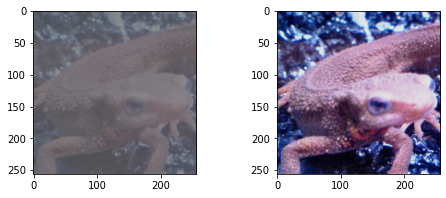

In [19]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(img_dark)
plt.subplot(1, 2, 2)
plt.imshow(hist_equalize(img_dark, 230))

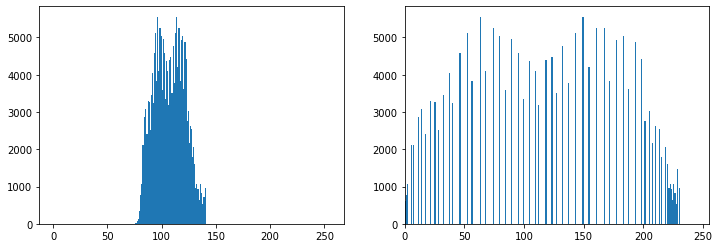

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.hist(img_dark.ravel(), bins=255, range=(0, 255));
plt.subplot(1, 2, 2); plt.hist(hist_equalize(img_dark, 230).ravel(), bins=255, range=(0, 255));
plt.xlim([0, 255]); plt.show()

## Question 24 ガンマ補正 Gamma correction

imori_256x256_gamma.jpg に対してガンマ補正(c=1, g=2.2)を実行せよ。

ガンマ補正とは、カメラなどの媒体の経由によって画素値が非線形的に変換された場合の補正である。 ディスプレイなどで画像をそのまま表示すると画面が暗くなってしまうため、RGBの値を予め大きくすることで、ディスプレイの特性を排除した画像表示を行うことがガンマ補正の目的である。

非線形変換は次式で起こるとされる。 ただし xは[0,1] に正規化されている。

c ... 定数

g ... ガンマ特性(通常は2.2)

![](https://github.com/yoyoyo-yo/Gasyori100knock/raw/master/questions/question_21_30/images/gamma_equ.png)

MEMO: 画像データの入出力機器はそれぞれ固有のガンマ値を持っている。画像の入力から最終出力までの全体のガンマが1になるよう、適当なガンマ値のカーブに従って画像の階調を補正することをガンマ補正という。

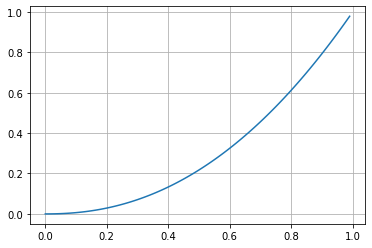

In [21]:
x = np.arange(0, 1, 0.01); plt.plot(x, x ** 2.2); plt.grid(); plt.show()

これを線形に直すために次式の補正を掛ける

![](https://github.com/yoyoyo-yo/Gasyori100knock/raw/master/questions/question_21_30/images/gamma_corr_equ.png)

これは $0 \leq x \leq 1$ なので、 $0 \leq x \leq 255$ に逆正規化する必要がある

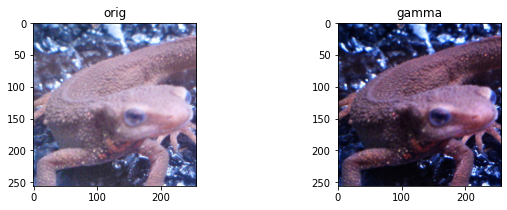

In [22]:
img_gamma = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_gamma.png')
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1); plt.imshow(img_orig); plt.title('orig')
plt.subplot(1, 2, 2); plt.imshow(img_gamma); plt.title('gamma')
plt.show()

In [23]:
def gamma_correction(img, c=1, g=2.2):
    out = ((1 / c) * (img / 255)) ** (1 / g)
    out = 255 * out
    return np.clip(out, 0, 255).astype(np.uint8)

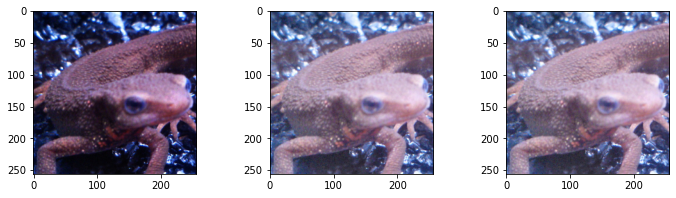

In [24]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1); plt.imshow(img_gamma)
plt.subplot(1, 3, 2); plt.imshow(gamma_correction(img_gamma))
plt.subplot(1, 3, 3); plt.imshow(img_orig)
plt.show()

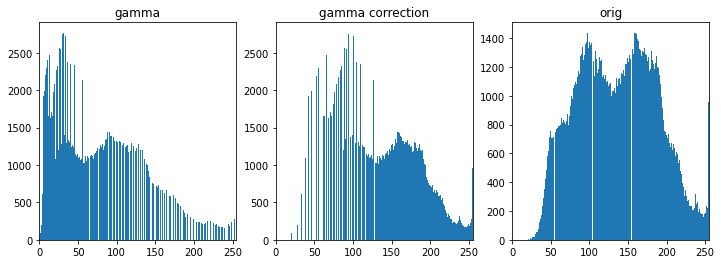

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.hist(img_gamma.ravel(), bins=255); plt.xlim([0, 255]); plt.title('gamma')
plt.subplot(1, 3, 2); plt.hist(gamma_correction(img_gamma).ravel(), bins=255); plt.xlim([0, 255]); plt.title('gamma correction')
plt.subplot(1, 3, 3); plt.hist(img_orig.ravel(), bins=255); plt.xlim([0, 255]); plt.title('orig')
plt.show()

## Question 25 最近傍補間 Nearest neighbour interpolation (NN法)

最近傍補間により画像を1.5倍に拡大せよ。

最近傍補間(Nearest Neighbor)は画像の拡大時に最近傍にある画素をそのまま使う手法である。 シンプルで処理速度が速いが、画質の劣化は著しい。

画像が縦a倍、横b倍になったとすると、拡大後の画像のx, yはそれぞれ次式となる。拡大後x'の位置のピクセルは元画像のx/aの位置の画素値が当てはまることを意味する。

- y' = round(y / a)
- x' = round(x / a)

MEMO: use `floor()` instead of `round()`

In [63]:
def nn_inter(img, a=2, b=2):
    out_h = int(img.shape[0] * a)
    out_w = int(img.shape[1] * b)
    out = np.zeros([out_h, out_w, img.shape[2]], dtype=np.uint8)
    
    ys, xs = np.meshgrid(range(out_h - 1), range(out_w - 1))
    out[ys, xs] = img[np.floor(ys / a).astype(int), np.floor(xs / b).astype(int)]
    return out

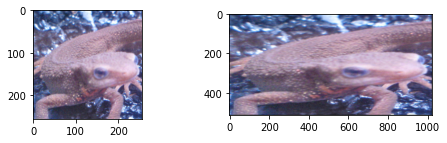

In [64]:
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1); plt.imshow(img_orig)
plt.subplot(1, 2, 2); plt.imshow(nn_inter(img_orig, 2, 4))
plt.show()

## Question 26 バイリニア補間 Bi-linear interpolation

Bi-linear補間により画像を1.5倍に拡大せよ。

Bi-linear補間とは周辺の４画素に距離に応じた重みをつけることで補完する手法である。 計算量が多いだけ処理時間がかかるが、画質の劣化を抑えることができる。 縦にa倍、横にb倍にする場合で考える。

1. 拡大画像の座標(x', y')を拡大率で割り、x = floor(x'/b), y = floor(y'/a) を求める。
2. 元画像の(x'/b, y'/a)の周囲4画素、I(x,y), I(x+1,y), I(x,y+1), I(x+1, y+1)を求める

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_21_30/images/bli_fig.png)

3. それぞれの画素と(x'/b, y'/a)との距離dを求め、重み付けする。
4. 次式によって拡大画像の画素(x',y')を求める。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_21_30/images/bli_equ.png)

参考: https://www.youtube.com/watch?v=AqscP7rc8_M&ab_channel=Computerphile

In [88]:
def bilinear_inter(img, a=2, b=2):
    h, w, c = img.shape
    out_h = int(h * a)
    out_w = int(w * b)

    xs, ys = np.meshgrid(range(out_w), range(out_h))

    _xs = np.floor(xs / b).astype(int)
    _ys = np.floor(ys / a).astype(int)

    dx = xs / b - _xs
    dy = ys / a - _ys

    dx = np.repeat(np.expand_dims(dx, axis=-1), c, axis=-1)
    dy = np.repeat(np.expand_dims(dy, axis=-1), c, axis=-1)

    # handle edges
    _xs1p = np.minimum(_xs + 1, w - 1)
    _ys1p = np.minimum(_ys + 1, h - 1)

    # interpolate
    out = (1 - dx) * (1 - dy) * img[_ys, _xs] + dx * (1 - dy) * img[_ys, _xs1p] + (1 - dx) * dy * img[_ys1p, _xs] + dx * dy * img[_ys1p, _xs1p]

    return np.clip(out, 0, 255).astype(np.uint8)

In [85]:
w, h = 3, 3
a, b = 3, 3
out_w, out_h = 9, 9
xs, ys = np.meshgrid(range(out_w), range(out_h))
print(xs, ys)

[[0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]
 [0 1 2 3 4 5 6 7 8]] [[0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5 5 5]
 [6 6 6 6 6 6 6 6 6]
 [7 7 7 7 7 7 7 7 7]
 [8 8 8 8 8 8 8 8 8]]


In [81]:
_xs = np.floor(xs / b).astype(int)
_ys = np.floor(ys / a).astype(int)
print(_xs, _ys)

[[0 0 0 1 1 1 2 2 2]
 [0 0 0 1 1 1 2 2 2]
 [0 0 0 1 1 1 2 2 2]
 [0 0 0 1 1 1 2 2 2]
 [0 0 0 1 1 1 2 2 2]
 [0 0 0 1 1 1 2 2 2]
 [0 0 0 1 1 1 2 2 2]
 [0 0 0 1 1 1 2 2 2]
 [0 0 0 1 1 1 2 2 2]] [[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2]]


In [83]:
dx = xs / b - _xs
dy = ys / b - _ys
print(dx, dy)

[[0.         0.33333333 0.66666667 0.         0.33333333 0.66666667
  0.         0.33333333 0.66666667]
 [0.         0.33333333 0.66666667 0.         0.33333333 0.66666667
  0.         0.33333333 0.66666667]
 [0.         0.33333333 0.66666667 0.         0.33333333 0.66666667
  0.         0.33333333 0.66666667]
 [0.         0.33333333 0.66666667 0.         0.33333333 0.66666667
  0.         0.33333333 0.66666667]
 [0.         0.33333333 0.66666667 0.         0.33333333 0.66666667
  0.         0.33333333 0.66666667]
 [0.         0.33333333 0.66666667 0.         0.33333333 0.66666667
  0.         0.33333333 0.66666667]
 [0.         0.33333333 0.66666667 0.         0.33333333 0.66666667
  0.         0.33333333 0.66666667]
 [0.         0.33333333 0.66666667 0.         0.33333333 0.66666667
  0.         0.33333333 0.66666667]
 [0.         0.33333333 0.66666667 0.         0.33333333 0.66666667
  0.         0.33333333 0.66666667]] [[0.         0.         0.         0.         0.         0.
  0

In [86]:
_xs1p = np.minimum(_xs + 1, w - 1)
_ys1p = np.minimum(_ys + 1, h - 1)
print(_xs1p, _ys1p)

[[1 1 1 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2]
 [1 1 1 2 2 2 2 2 2]] [[1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2]]


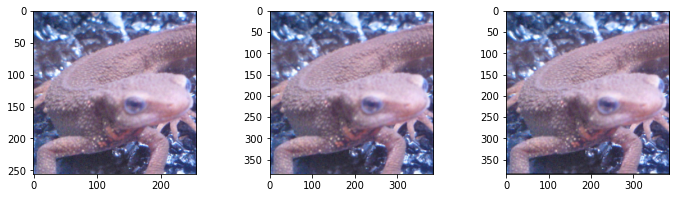

In [77]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1); plt.imshow(img_orig)
plt.subplot(1, 3, 2); plt.imshow(bilinear_inter(img_orig, 1.5, 1.5))
plt.subplot(1, 3, 3); plt.imshow(nn_inter(img_orig, 1.5, 1.5))
plt.show()

## Question 27 Bi-cubic補間 Bi-cubic interpolation

Bi-cubic補間により画像を1.5倍に拡大せよ。

Bi-cubic補間とはBi-linear補間の拡張であり、周辺の16画素から補間を行う。 縦にa倍、横にb倍にする場合で考える。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_21_30/images/bci_fig.png)

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_21_30/images/bci_equ.png)

参考: https://www.youtube.com/watch?v=poY_nGzEEWM&t=322s&ab_channel=Computerphile

In [89]:
def bicubic_inter(img, a=2, b=2):
    h, w, c = img.shape
    out_h = int(h * a)
    out_w = int(w * b)
    out = np.zeros([out_h, out_w, c], dtype=np.float32)

    xs, ys = np.meshgrid(range(out_w), range(out_h))

    _xs = np.floor(xs / b).astype(int)
    _ys = np.floor(ys / a).astype(int)

    dx1 = np.abs(xs / b - (_xs - 1))
    dx2 = np.abs(xs / b - _xs)
    dx3 = np.abs(xs / b - (_xs + 1))
    dx4 = np.abs(xs / b - (_xs + 2))
    dy1 = np.abs(ys / a - (_ys - 1))
    dy2 = np.abs(ys / a - _ys)
    dy3 = np.abs(ys / a - (_ys + 1))
    dy4 = np.abs(ys / a - (_ys + 2))

    dxs = [dx1, dx2, dx3, dx4]
    dys = [dy1, dy2, dy3, dy4]

    def weight(t, a=-1):
        w = np.zeros_like(t)
        w[t <= 1] = ((a + 2) * (t ** 3) - (a + 3) * (t ** 2) + 1)[t <= 1]
        w[t > 1] = (a * (t ** 3) - 5 * a * (t ** 2) + 8 * a * t - 4 * a)[t > 1]
        return w

    w_sum = np.zeros_like(out, dtype=np.float32)

    for j in range(-1, 3):
        for i in range(-1, 3):
            ind_x = np.minimum(np.maximum(_xs + i, 0), w - 1)
            ind_y = np.minimum(np.maximum(_ys + j, 0), h - 1)

            wx = weight(dxs[i + 1])
            wy = weight(dys[j + 1])
            wx = np.repeat(np.expand_dims(wx, axis=-1), 3, axis=-1)
            wy = np.repeat(np.expand_dims(wy, axis=-1), 3, axis=-1)

            w_sum += wx * wy
            out += wx * wy * img[ind_y, ind_x]
    
    return np.clip(out, 0, 255).astype(np.uint8)
    

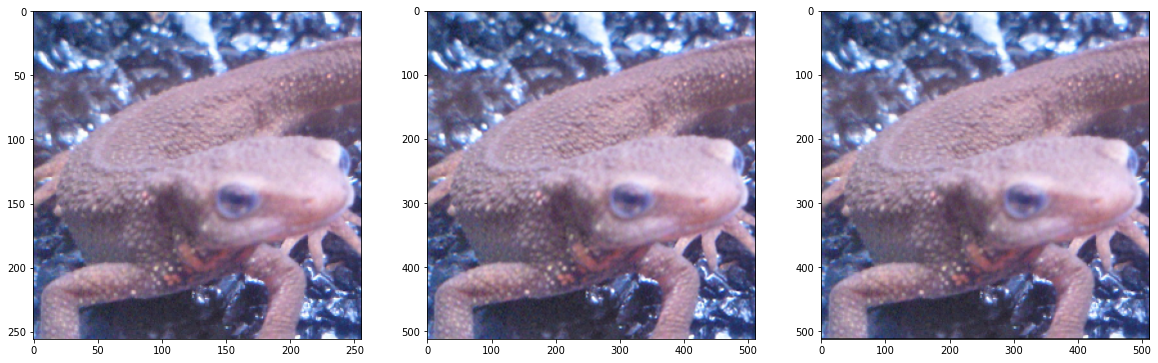

In [94]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 3, 1); plt.imshow(img_orig)
plt.subplot(1, 3, 2); plt.imshow(bicubic_inter(img_orig, 2, 2))
plt.subplot(1, 3, 3); plt.imshow(nn_inter(img_orig, 2, 2))
plt.show()

## Question 28 アフィン変換（平行移動） Affine shift

アフィン変換を利用して画像をx方向に+30、y方向に-30だけ平行移動させよ。

アフィン変換とは3x3の行列を用いて画像の変換を行う操作である。

変換は(1) 平行移動(Q.28) (2) 拡大縮小(Q.29) (3) 回転(Q.30) (4) スキュー(Q.31) がある。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_21_30/images/affine_equ.png)

参考: https://www.youtube.com/watch?v=E3Phj6J287o&ab_channel=LeiosOS

In [128]:
def affine(img, affine_mat, out_shape):
    h, w, ch = img.shape

    [a, b, tx], [c, d, ty] = affine_mat
    out_h, out_w = out_shape

    out = np.zeros([out_h, out_w, ch])

    img_pad = np.pad(img, [(1,1), (1,1), (0,0)])

    xs, ys = np.meshgrid(range(out_w), range(out_h))

    _xs = np.maximum(np.minimum((1 / (a * d - b * c) * (d * xs - b * ys) - tx).astype(int) + 1, w + 1), 0)
    _ys = np.maximum(np.minimum((1 / (a * d - b * c) * (-c * xs + a * ys) - ty).astype(int) + 1, h + 1), 0)

    out[ys, xs] = img_pad[_ys, _xs]
    return np.clip(out, 0, 255).astype(np.uint8)

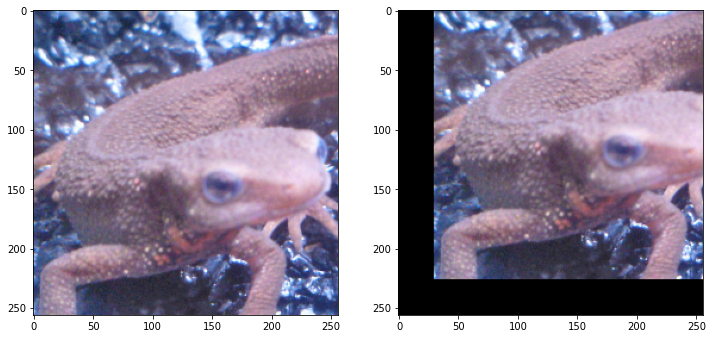

In [129]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1); plt.imshow(img_orig)
plt.subplot(1, 2, 2); plt.imshow(affine(img_orig, [[1, 0, 30], [0, 1, -30]], (img_orig.shape[0], img_orig.shape[1])))
plt.show()

## Question 29 アフィン変換（拡大縮小） Affine scale

アフィン変換を用いて、(1)x方向に1.3倍、y方向に0.8倍にリサイズせよ。

また、(2) (1)の条件に加えて、x方向に+30、y方向に-30だけ平行移動を同時に実現せよ。

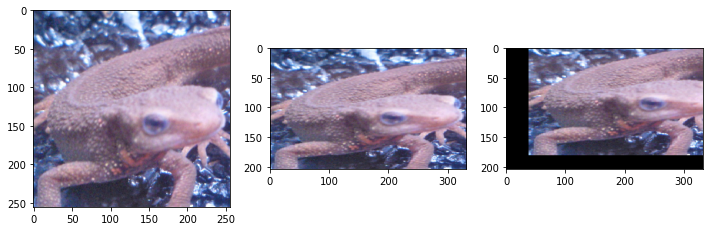

In [134]:
plt.figure(figsize=(12, 9))
plt.subplot(1, 3, 1); plt.imshow(img_orig)
plt.subplot(1, 3, 2); plt.imshow(affine(img_orig, [[1.3, 0, 0], [0, 0.8, 0]], (int(img_orig.shape[0] * 0.8), int(img_orig.shape[1] * 1.3))))
plt.subplot(1, 3, 3); plt.imshow(affine(img_orig, [[1.3, 0, 30], [0, 0.8, -30]], (int(img_orig.shape[0] * 0.8), int(img_orig.shape[1] * 1.3))))
plt.show()

## Question 30 アフィン変換（回転） Affine rotation

(1)アフィン変換を用いて、反時計方向に30度回転させよ。

(2) アフィン変換を用いて、反時計方向に30度回転した画像で中心座標を固定することで、なるべく黒い領域がなくなるように画像を作成せよ。 （ただし、単純なアフィン変換を行うと画像が切れてしまうので、工夫を要する。）

アフィン変換において、反時計方向にA度回転させる時は、次式となる。

![](https://raw.githubusercontent.com/yoyoyo-yo/Gasyori100knock/master/questions/question_21_30/images/affine_rot_equ.png)

MEMO: 上式、時計回り

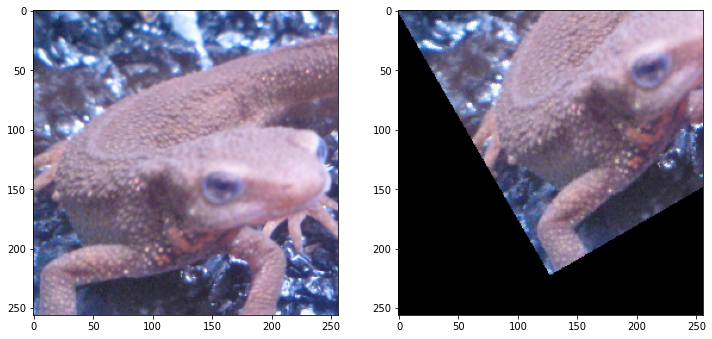

In [136]:
import math

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1); plt.imshow(img_orig)
plt.subplot(1, 2, 2); plt.imshow(affine(img_orig, [[math.cos(math.radians(30)), math.sin(math.radians(30)), 0], [-math.sin(math.radians(30)), math.cos(math.radians(30)), 0]], (img_orig.shape[0], img_orig.shape[1])))
plt.show()